In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import signal
import numpy as np
import pandas as pd
import seaborn as sns
import json

In [2]:
class JSONUtil(object):
    
    def __init__(self):
        self.joint_data = []
        self.video_meta = []
        
    def glob_json(self, process_callback):
        p = Path('./json/data')
        for file in p.glob('*.json'):
            print('[*]  Processing file: {0}'.format(file.name))
            process_callback('./json/data/' + file.name) #'./json/'
        
    def process_json(self, jsonfile):
        with open(jsonfile) as file:
            joint_data = json.load(file)
        
        frameattime_list = []
        joint_positions = {}
        dict_list = joint_data['frames']
        for _dict in dict_list:
            frame = _dict['frame']
            time = _dict['time']
            frameattime_list.append((frame, time))

            for data in _dict['data']:
                jkey = data['part']
                pos = data['position']
                xy = np.asarray((pos['x'], pos['y']), dtype=np.float).reshape(1, 2)

                if not jkey in joint_positions:
                    joint_positions[jkey] = xy
                else:
                    prev = joint_positions[jkey]
                    joint_positions[jkey] = np.append(prev, xy, axis=0)
        
        self.joint_data.append(joint_positions)
        self.video_meta.append({
            'category': joint_data['category'],
            'file': joint_data['filename'],
            'videoStart': joint_data['videoStart'],
            'videoEnd': joint_data['videoEnd'],
            'totalFrames': joint_data['totalFrames'],
            'frameTime': frameattime_list
        })
        
    def extract_json(self):
        self.glob_json(self.process_json)
        return self.joint_data, self.video_meta
    

In [3]:
class LabanUtil(object):
    
    def __init__(self):
        pass
        
    @staticmethod
    def dist_between(p0, p1, ax=1):
        return np.linalg.norm(p0 - p1, ord=None, axis=ax)
    
    @staticmethod
    def assert_filt(c1, c2):
        assert c1.shape == c2.shape, \
            'shape1 {0} != shape2 {1}'.format(c1.shape, c2.shape)
    
    @staticmethod
    def avgfilter(inp, npoints):
        if len(inp.shape) is 1:
            shape = (npoints, )
        else:
            shape = (npoints, inp.shape[1])

        coef = 1. / float(npoints)
        transients = np.zeros(shape)
        vals = np.concatenate((transients, inp), axis=0)    
        end = vals.shape[0]

        y = np.zeros_like(inp)
        for p in range(npoints):
            y = y + vals[npoints-p:end-p]*coef
        
        LabanUtil.assert_filt(y, inp)
        return y
    
    @staticmethod
    def lpfilter(inp):
        b, a = signal.butter(3, 0.15)
        return signal.filtfilt(b, a, inp)
    

In [4]:
class RawGesture(object):
    
    def __init__(self, lma_data):
        self.lma_data = lma_data
        self.lma_features_symbolic = {}
        
        maxReach = 0.75
        frameRate = lma_data[0]
        
        nrm = lma_data[1];
        pos = lma_data[2];
        vel = lma_data[3];
        acc = lma_data[4];
        ios = lma_data[5]; 
        
        pos[:, 0] /= nrm[0]
        pos[:, 1] /= nrm[1]
        
        dur_ms = ((ios[1] - ios[0]) / frameRate) * 1000.        
        tot_dist_mm = np.sum(
            LabanUtil.dist_between(pos[0:len(pos)-1], pos[1:len(pos)])
        ) * maxReach * 1000. 
        dist_mod = LabanUtil.dist_between(pos[0], pos[len(pos)-1], 0) * maxReach * 1000.
        avg_speed = tot_dist_mm / dur_ms
        l_ratio = tot_dist_mm / dist_mod
        abs_accel = np.mean(np.abs(acc))
        a_ratio = np.abs(np.mean(acc[acc >= 0]) / np.mean(acc[acc < 0]))
        x_dir = np.sign(pos[0][0] - pos[len(pos)-1][0])
        y_dir = np.sign(pos[0][1] - pos[len(pos)-1][1])
        
        self.lma_features_raw = [
            dur_ms, tot_dist_mm, dist_mod,
            avg_speed, l_ratio, abs_accel,
            a_ratio, x_dir, y_dir
        ]                
        
    def get_raw_features(self):
        return self.lma_features_raw
    
    def symbolic_space(self, t):
        thresh = t
        l_ratio = self.lma_features_raw[4]
        return 'direct' if l_ratio <= thresh else 'indirect'

    def symbolic_weight(self, t):
        y_dir = self.lma_features_raw[8]
        a_ratio = self.lma_features_raw[6]
        abs_accel = self.lma_features_raw[5]
        strength_factor = t
        
        up = y_dir <= 0.
        down = y_dir > 0.
        
        query1 = (a_ratio > 1. and up) or (a_ratio < 1. and down)
        query2 = abs_accel > strength_factor
        
        out = ''
        if query1 and query2:
            out = 'strong'
        elif query1 or query2:
            out = 'neutral'
        else:
            out = 'light'
            
        return out
        
    def symbolic_time(self, t1, t2):
        dur = self.lma_features_raw[0]
        abs_accel = self.lma_features_raw[5]
        dur_thresh = t1
        strength_factor = t2
        
        query1 = dur < 2000. #dur_thresh
        query2 = abs_accel > strength_factor
        
        out = ''
        if query1 and query2:
            out = 'sudden'
        elif query1 or query2:
            out = 'neutral'
        else:
            out = 'sustained'
            
        return out
    
    def effort_action(self, encoding, thresholds):
        
        t = thresholds
        space_factor = self.symbolic_space(t[1])
        weight_factor = self.symbolic_weight(t[3])
        time_factor = self.symbolic_time(t[0], t[2])
        return encoding[space_factor][weight_factor][time_factor]


In [5]:
class LabanApproximator(object):
    
    def __init__(self, data, meta=None):
        
        self.frameRate = 30.
        if meta:
            vs = meta['videoStart']
            ve = meta['videoEnd']
            nf = meta['totalFrames']
            self.frameRate = nf / (ve - vs)
        
        self.joint_positions = {}
        self.joint_velocities = {}
        self.joint_accelerations = {}
        
        self.joint_accelerations_unfiltered = {}
        
        self.joint_gesture_interonsets = {}
        self.joint_gestures = {}
        
        neck = (data['leftShoulder'] + data['rightShoulder']) / 2.
        hip = (data['leftHip'] + data['rightHip']) / 2.
        torso = (neck + hip) / 2.
        
        lWrist = data['leftWrist']
        rWrist = data['rightWrist']
        lMax_x = np.amax(np.abs(lWrist[:,0] - torso[:,0]))
        lMax_y = np.amax(np.abs(lWrist[:,1] - torso[:,1]))
        rMax_x = np.amax(np.abs(rWrist[:,0] - torso[:,0]))
        rMax_y = np.amax(np.abs(rWrist[:,1] - torso[:,1]))
        
        self.max_x = max(lMax_x, rMax_x)
        self.max_y = max(lMax_y, rMax_y)
        
        head_sum = np.zeros_like(data['nose'])
        exclude_keys = ['nose', 'leftEye', 'rightEye', 'leftEar', 'rightEar']
        
        for k in exclude_keys:
            head_sum = head_sum + data[k]*0.2
        
        head_sum = head_sum - torso        
        self.joint_positions['head'] = LabanUtil.avgfilter(head_sum, npoints=2)
        
        for jkey in [key for key in data if key not in exclude_keys]:
            new_pos = data[jkey] - torso 
            self.joint_positions[jkey] = LabanUtil.avgfilter(new_pos, npoints=2)
            
        self.calc_velocity()
        self.calc_acceleration()
        self.detect_gesture()
        self.calc_gestures()
            
    def calc_velocity(self):
        assert bool(self.joint_positions), 'No spatial data available'
        
        for jkey in self.joint_positions:
            position = self.joint_positions[jkey]
            velocity = np.zeros(position.shape[0])
            velocity[1:] = LabanUtil.dist_between(position[1:], position[0:len(position)-1]) 
            self.joint_velocities[jkey] = LabanUtil.avgfilter(velocity, npoints=7)
    
    def calc_acceleration(self):
        assert bool(self.joint_velocities), 'No temporal data available'
        
        for jkey in self.joint_velocities:
            velocity = self.joint_velocities[jkey]
            acceleration = np.zeros(velocity.shape[0])
            acceleration[1:] = velocity[1:] - velocity[0:len(velocity)-1]
            self.joint_accelerations_unfiltered[jkey] = LabanUtil.avgfilter(acceleration, npoints=3)
            self.joint_accelerations[jkey] = LabanUtil.lpfilter(acceleration)
    
    def locate_2nd_zero(self, idx, onset, in_arr, out_arr):
        new_offset = idx
        zero_crossings = np.where(np.diff(np.signbit(in_arr)))[0]

        if len(zero_crossings) > 1:
            idx = zero_crossings[1]
            out_arr.append((onset, onset+idx))
            new_offset = onset+idx
        
        return new_offset
        
    def locate_threshold(self, in_arr, from_idx, to_idx, thresh, out_arr):
        new_offset = from_idx
        _slice = in_arr[from_idx:to_idx]
        for idx, val in enumerate(_slice):
            if val > thresh:
                new_offset = self.locate_2nd_zero(
                    idx=from_idx,
                    onset=from_idx+idx, 
                    in_arr=_slice[idx:], 
                    out_arr=out_arr
                )
                break
                
        return new_offset + 1
    
    def detect_gesture(self):
        for jkey in self.joint_accelerations:
            acc = self.joint_accelerations[jkey]
            acc_norm = acc / np.amax(acc)
            thresh = 0.5
            
            itr = 0
            end = len(acc_norm)
            gesture_track = []
            
            while itr < end:
                new_offset = self.locate_threshold(
                    in_arr=acc_norm,
                    from_idx=itr,
                    to_idx=end,
                    thresh=thresh,
                    out_arr=gesture_track
                )
                
                itr = new_offset
            
            self.joint_gesture_interonsets[jkey] = gesture_track
    
    def calc_gestures(self):
        assert bool(self.joint_gesture_interonsets), 'No gestures detected' 
        
        for jkey in self.joint_gesture_interonsets:
            self.joint_gestures[jkey] = []
            for interonset in self.joint_gesture_interonsets[jkey]:
                lo = interonset[0]
                hi = interonset[1]
                lma_data = (
                        self.frameRate,
                        (self.max_x, self.max_y),
                        self.joint_positions[jkey][lo:hi],
                        self.joint_velocities[jkey][lo:hi],
                        self.joint_accelerations_unfiltered[jkey][lo:hi],
                        interonset
                    )
                
                self.joint_gestures[jkey].append(RawGesture(lma_data))
    
    def calculate_action_effort(self, encoding, thresholds):
        
        actions = []
        gest = self.joint_gestures
        for joint in gest:
            detected_gestures = gest[joint]
            for raw_gesture in detected_gestures:
                action = raw_gesture.effort_action(encoding, thresholds[joint])
                actions.append(action)
                
        return actions
    
    def pretty_print(self, for_joint):
        
        print('\n\n[{0}] Outputting values for features'.format(for_joint))
        gesture_features = self.joint_gestures[for_joint]
        if not gesture_features:
            print('No gestures detected for this joint')
            return
        
        labels = [
            ('Duration          ', 'ms'), ('Total Displacement', 'mm'), ('Displacement      ', 'mm'),
            ('Mean Speed        ', 'mm/ms'), ('L Ratio           ' , '-'), ('Mean Acceleration ', '-'),
            ('A Ratio           ', '-'), ('X Dir             ', '-'), ('Y Dir             ', '-')
        ]
        
        for feature in gesture_features:
            print('[  Feature           | Value  |\tUnit\t]')
            for idx, feat in enumerate(feature.lma_features_raw):
                lab = labels[idx][0]
                unit = labels[idx][1]
                val = '%.2f' %(feat)
                print('[* {0}: {1}\t{2}\t]'.format(lab, val, unit))
                
            print('\n\n')
        
    def plot_gesture_interonsets(self):
        
        def trim_axs(axs, n):
            axs = axs.flat
            for ax in axs[n:]:
                ax.remove()
            return axs[:n]
        
        def plot_onsets(ax, onsets, case, xrange):
            subcase = np.copy(case).astype(float)
            for r in onsets:
                lo = r[0]
                hi = r[1]
                
                subcase[lo:hi] = np.nan
                subsubcase = np.copy(case).astype(float)
                subsubcase[:lo] = np.nan
                subsubcase[hi:] = np.nan
                ax.plot(xrange, subsubcase, 'r')
                
            ax.plot(xrange, subcase)
            
        onsets = self.joint_gesture_interonsets
        cases = self.joint_accelerations
        nofilter = self.joint_accelerations_unfiltered
        figsize = (10, 8)
        cols = 3
        rows = len(onsets) // cols + 1
        
        fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
        axs = trim_axs(axs, len(cases))
        
        for ax, onset in zip(axs, onsets):
            ax.set_title('{0}'.format(onset))
            xrange = np.arange(0, len(cases[onset]))
            ax.plot(xrange, nofilter[onset], 'k', alpha=0.3)
            plot_onsets(ax, onsets[onset], cases[onset], xrange)
        
        plt.show()
        return fig

In [6]:
class LMARunner(object):
    
    def __init__(self, all_data, all_meta, thresholds=None):
        
        self.action_encoding = {
            'direct': {
                'strong': {
                    'sudden': 'punch',
                    'sustained': 'press',
                    'neutral': 'punch'
                },
                'light' : {
                    'sudden': 'dab',
                    'sustained': 'glide', 
                    'neutral': 'glide'
                },
                'neutral': {
                    'sudden': 'punch', 
                    'sustained': 'glide', 
                    'neutral': 'neutral'
                }
            },
            'indirect': {
                'strong': {
                    'sudden': 'slash',
                    'sustained': 'wring',
                    'neutral': 'slash'
                },
                'light' : {
                    'sudden': 'flick',
                    'sustained': 'float', 
                    'neutral': 'float'
                },
                'neutral': {
                    'sudden': 'slash', 
                    'sustained': 'float', 
                    'neutral': 'neutral'
                }
            }
        }
        
        self.joint_keys = [
            'head', 'leftShoulder', 'rightShoulder', 'leftElbow', 'rightElbow',
            'leftWrist', 'rightWrist', 'leftHip', 'rightHip', 'leftKnee', 'rightKnee',
            'leftAnkle', 'rightAnkle'
        ]
                
        self.lma_approximations = []
        self.lma_metadata = []
        
        for data, meta in zip(all_data, all_meta):
            lma = LabanApproximator(data, meta)
            self.lma_approximations.append(lma)
            self.lma_metadata.append(meta)
            
        self.lma_wrapper = list(zip(self.lma_approximations, self.lma_metadata))
        self.categories = self.sort_categorical()

        if thresholds:
            self.analytic_thresholds = thresholds
        else:
            self.analytic_thresholds = self.estimate_analytic_thresholds()
        
        #print(self.analytic_thresholds)
        
    def load_thresholds(self):
        # load thresholds from .json on disc
        # move to JSONUtil
        pass
    
    def save_threshold(self):
        # save analytically calculated thresholds to disc
        # move to JSONUtil
        pass
    
    def estimate_analytic_thresholds(self):
        analytic_thresholds = {}
        for cat in self.categories:
            analytic_thresholds[cat] = {}
            joint_raw = self.extract_raw_features(self.categories[cat])  
            for key in self.joint_keys:
                analytic_thresholds[cat][key] = \
                    self.estimate_threshold(joint_raw[key])
                
        return analytic_thresholds
    
    def estimate_threshold(self, feature_list):

        # duration         0
        # L Ratio          4    
        # abs acceleration 5
        
        ind = [0, 4, 5]
        thresholds = []
        for i in ind:
            _, bins = np.histogram(feature_list[i], bins=3)
            
            if i is 5:
                lower = bins[1]
                upper = bins[2]
                thresholds.append(lower)
                thresholds.append(upper)
                continue
            
            t = bins[1]
            thresholds.append(t)
            
        return thresholds
    
    def extract_raw_features(self, lma_approximations):
        joint_raw_features = {}
        for key in self.joint_keys:
            nested = []
            for i in range(0, 9):
                nested.append([])
                
            joint_raw_features[key] = nested
                
        for lma in lma_approximations:
            joint_gestures = lma.joint_gestures
            for key in self.joint_keys:
                li = joint_raw_features[key]
                for detected_gesture in joint_gestures[key]:
                    raw_features = detected_gesture.get_raw_features()
                    for idx, feature in enumerate(raw_features):
                        li[idx].append(feature)
        
        return joint_raw_features
    
    def sort_categorical(self):
        lma_categorical = {}
        for meta in self.lma_metadata:
            lma_categorical[meta['category']] = []
        
        for lma, meta in self.lma_wrapper:
            lma_categorical[meta['category']].append(lma)
        
        return lma_categorical
    
    def estimate_action_effort_for(self, lma_aproximation, cat):
        
        action_count = {
            'punch': 0,
            'dab'  : 0,
            'press': 0,
            'glide': 0,
            'slash': 0,
            'flick': 0,
            'wring': 0,
            'float': 0,
            'neutral': 0
        }
        
        actions = lma_aproximation.calculate_action_effort(
            self.action_encoding, 
            self.analytic_thresholds[cat]
        )
            
        for action in actions:
            action_count[action] += 1
        
        return action_count
    
    def get_action_efforts(self):
        assert bool(self.lma_wrapper), 'No data available'
        efforts = []
        for lma, meta in self.lma_wrapper:
            rendition = meta['file']
            category = meta['category']
            action_count = self.estimate_action_effort_for(lma, category)
            efforts.append((rendition, category, action_count))
            
        return efforts
    
    def get_features_categorical(self, cat):
        f = self.extract_raw_features(self.categories[cat])        
        return pd.DataFrame(f)
    

In [7]:
jsonutil = JSONUtil()
data, meta = jsonutil.extract_json()

[*]  Processing file: bolshoi ballets 11 01.json
[*]  Processing file: bolshoi ballets 11 02.json
[*]  Processing file: bolshoi ballets 11 03.json
[*]  Processing file: How to Do the Charleston Step _ Swing Dance 1.json
[*]  Processing file: How to Do the Charleston Step _ Swing Dance 3.json
[*]  Processing file: How to Do the Charleston Step _ Swing Dance 4.json
[*]  Processing file: How to Do the Charleston Step _ Swing Dance 5.json
[*]  Processing file: How to Do the Charleston Step _ Swing Dance 6.json
[*]  Processing file: How to Do the Charleston Step _ Swing Dance.2.json
[*]  Processing file: plum fairy 01.json
[*]  Processing file: plum fairy 02.json
[*]  Processing file: top fifteen 01.json
[*]  Processing file: top fifteen 02.json
[*]  Processing file: top fifteen 03.json


In [8]:
r = LMARunner(data, meta, thresholds=None)

action_efforts = r.get_action_efforts()
for a in action_efforts:
    f = a[0]
    c = a[1]
    d = a[2]
    print("Category: {0}".format(c))
    for k in d:
        print("{0}: {1}".format(k, d[k]))
    
    print("\n")

Category: Ballet
punch: 4
dab: 2
press: 0
glide: 42
slash: 0
flick: 0
wring: 0
float: 14
neutral: 12


Category: Ballet
punch: 0
dab: 0
press: 0
glide: 103
slash: 0
flick: 0
wring: 0
float: 11
neutral: 8


Category: Ballet
punch: 1
dab: 0
press: 0
glide: 62
slash: 0
flick: 0
wring: 0
float: 8
neutral: 7


Category: Swing
punch: 9
dab: 1
press: 0
glide: 8
slash: 0
flick: 0
wring: 0
float: 3
neutral: 16


Category: Swing
punch: 7
dab: 3
press: 0
glide: 5
slash: 0
flick: 0
wring: 0
float: 2
neutral: 10


Category: Swing
punch: 7
dab: 3
press: 0
glide: 9
slash: 2
flick: 4
wring: 0
float: 4
neutral: 3


Category: Swing
punch: 17
dab: 3
press: 0
glide: 5
slash: 5
flick: 2
wring: 0
float: 2
neutral: 9


Category: Swing
punch: 29
dab: 8
press: 0
glide: 12
slash: 12
flick: 0
wring: 0
float: 4
neutral: 15


Category: Swing
punch: 4
dab: 2
press: 0
glide: 17
slash: 0
flick: 0
wring: 0
float: 3
neutral: 17


Category: Ballet
punch: 29
dab: 12
press: 0
glide: 15
slash: 7
flick: 2
wring: 0
float: 2


{'head': [[559.4482758620692, 559.4482758620692, 885.7931034482762, 576.3855421686746, 1197.9746835443038, 1151.8987341772154, 578.2089552238799, 800.5970149253723, 1378.805970149252, 608.2568807339451, 608.2568807339451, 795.4128440366974, 795.4128440366974, 608.2568807339451, 748.6238532110093, 608.2568807339451, 655.6783919597992, 1358.1909547738699, 749.346733668342], [242.41816776927269, 202.06993071392236, 387.36717049875244, 166.68325399989132, 652.9736628257177, 814.1180973955768, 302.6636921186165, 545.8229681979733, 962.7546815297026, 122.0815805447178, 202.97662048971299, 418.90612513014224, 292.2270224526815, 226.5326645847438, 326.04358728790197, 216.0227866023323, 132.47780668673747, 391.9335476347886, 199.99537903572116], [35.405164326680776, 34.14483537272434, 66.44768635538506, 45.833374984564806, 82.29845127863337, 97.95239554450188, 70.02927657303835, 89.28917591378176, 36.037474866651166, 46.530479036669774, 17.560516323418852, 88.03966725284859, 186.45309310630665,

'\ncorr = df.corr()\nplt.figure(figsize=(10, 8))\nsns.heatmap(corr,\n            cmap=sns.diverging_palette(220, 10, as_cmap=True),\n            square=True,\n            xticklabels=labels,\n            yticklabels=labels)\n'

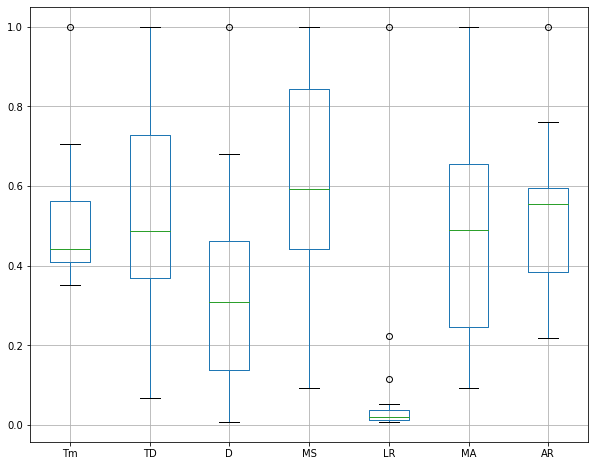

In [9]:

dat = r.get_features_categorical('Swing')
dat_f = np.asarray(dat['leftAnkle']).T
dat_f = dat_f[:, 0:7]

dat_norm = np.zeros_like(dat_f)
for c in range(0, 7):
    dat_norm[:, c] = dat_f[:, c] / np.amax(dat_f[:, c])

df = pd.DataFrame(dat_norm, columns=['Tm', 'TD', 'D', 'MS', 'LR', 'MA', 'AR'])
#print(df)

plt.figure(figsize=(10, 8))
bp = df.boxplot(return_type=None)

'''
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True,
            xticklabels=labels,
            yticklabels=labels)
'''

In [32]:
d = {
    "a": [[1, 2, 3], [4, 5, 6], [7, 8, 9]],
    "b": [[3, 2, 1], [6, 5, 4], [9, 8, 7]],
    "c": [[7, 8, 9], [6, 5, 4], [3, 2, 1]]
}
f = pd.DataFrame(d)
print(f)
print()

ff = f.iloc[0]
print(ff)

           a          b          c
0  [1, 2, 3]  [3, 2, 1]  [7, 8, 9]
1  [4, 5, 6]  [6, 5, 4]  [6, 5, 4]
2  [7, 8, 9]  [9, 8, 7]  [3, 2, 1]

a    [1, 2, 3]
b    [3, 2, 1]
c    [7, 8, 9]
Name: 0, dtype: object
